# Import necessary libraries

In [16]:
!python -m pip install pandas numpy matplotlib seaborn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 3.1 MB/s eta 0:00:00m eta 0:00:010:01:01


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
import seaborn as sns
import seaborn.objects as so

In [19]:
from scipy import stats

# Parse the data

In [20]:
STUDY = 'Study_Hours_Per_Day'
CLUBS = 'Extracurricular_Hours_Per_Day'
SLEEP = 'Sleep_Hours_Per_Day'
SOCIAL = 'Social_Hours_Per_Day'
PHYSICAL = 'Physical_Activity_Hours_Per_Day'
STRESS = 'Stress_Level'
GENDER = 'Gender'
GRADES = 'Grades'
STRESS_GROUPED = 'Stress_Grouped'

In [41]:
# Parse Dataframe
df = pd.read_csv(
    "student_lifestyles.csv", index_col=0
)
df = df.astype(dtype={'Stress_Level': 'category', 'Gender': 'category'})
df[STRESS_GROUPED] = df[STRESS].map({
    "Low": "Low/Moderate",
    "Moderate": "Low/Moderate",
    "High": "High"
}).astype("category")
print(df.dtypes)

Study_Hours_Per_Day                 float64
Extracurricular_Hours_Per_Day       float64
Sleep_Hours_Per_Day                 float64
Social_Hours_Per_Day                float64
Physical_Activity_Hours_Per_Day     float64
Stress_Level                       category
Gender                             category
Grades                              float64
Stress_Grouped                     category
dtype: object


In [42]:
num_df = df.drop([GENDER, STRESS, STRESS_GROUPED], axis=1)

# Explore Correlated data

In [43]:
corr = num_df.corr(method='spearman')

<Axes: >

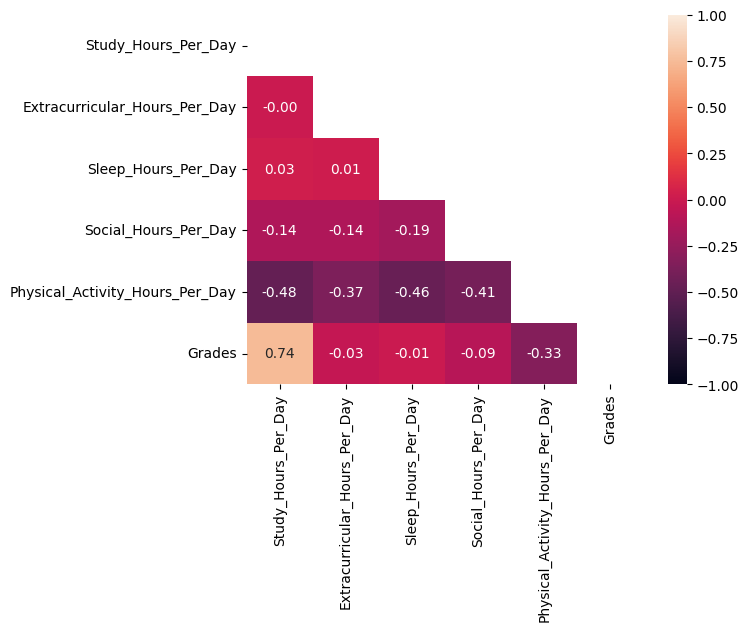

In [44]:
sns.heatmap(
    corr,
    cmap='rocket',
    annot=True,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    fmt=".2f",
    vmin=-1, vmax=1,
)

# The High Stress Heatmap is an outlier

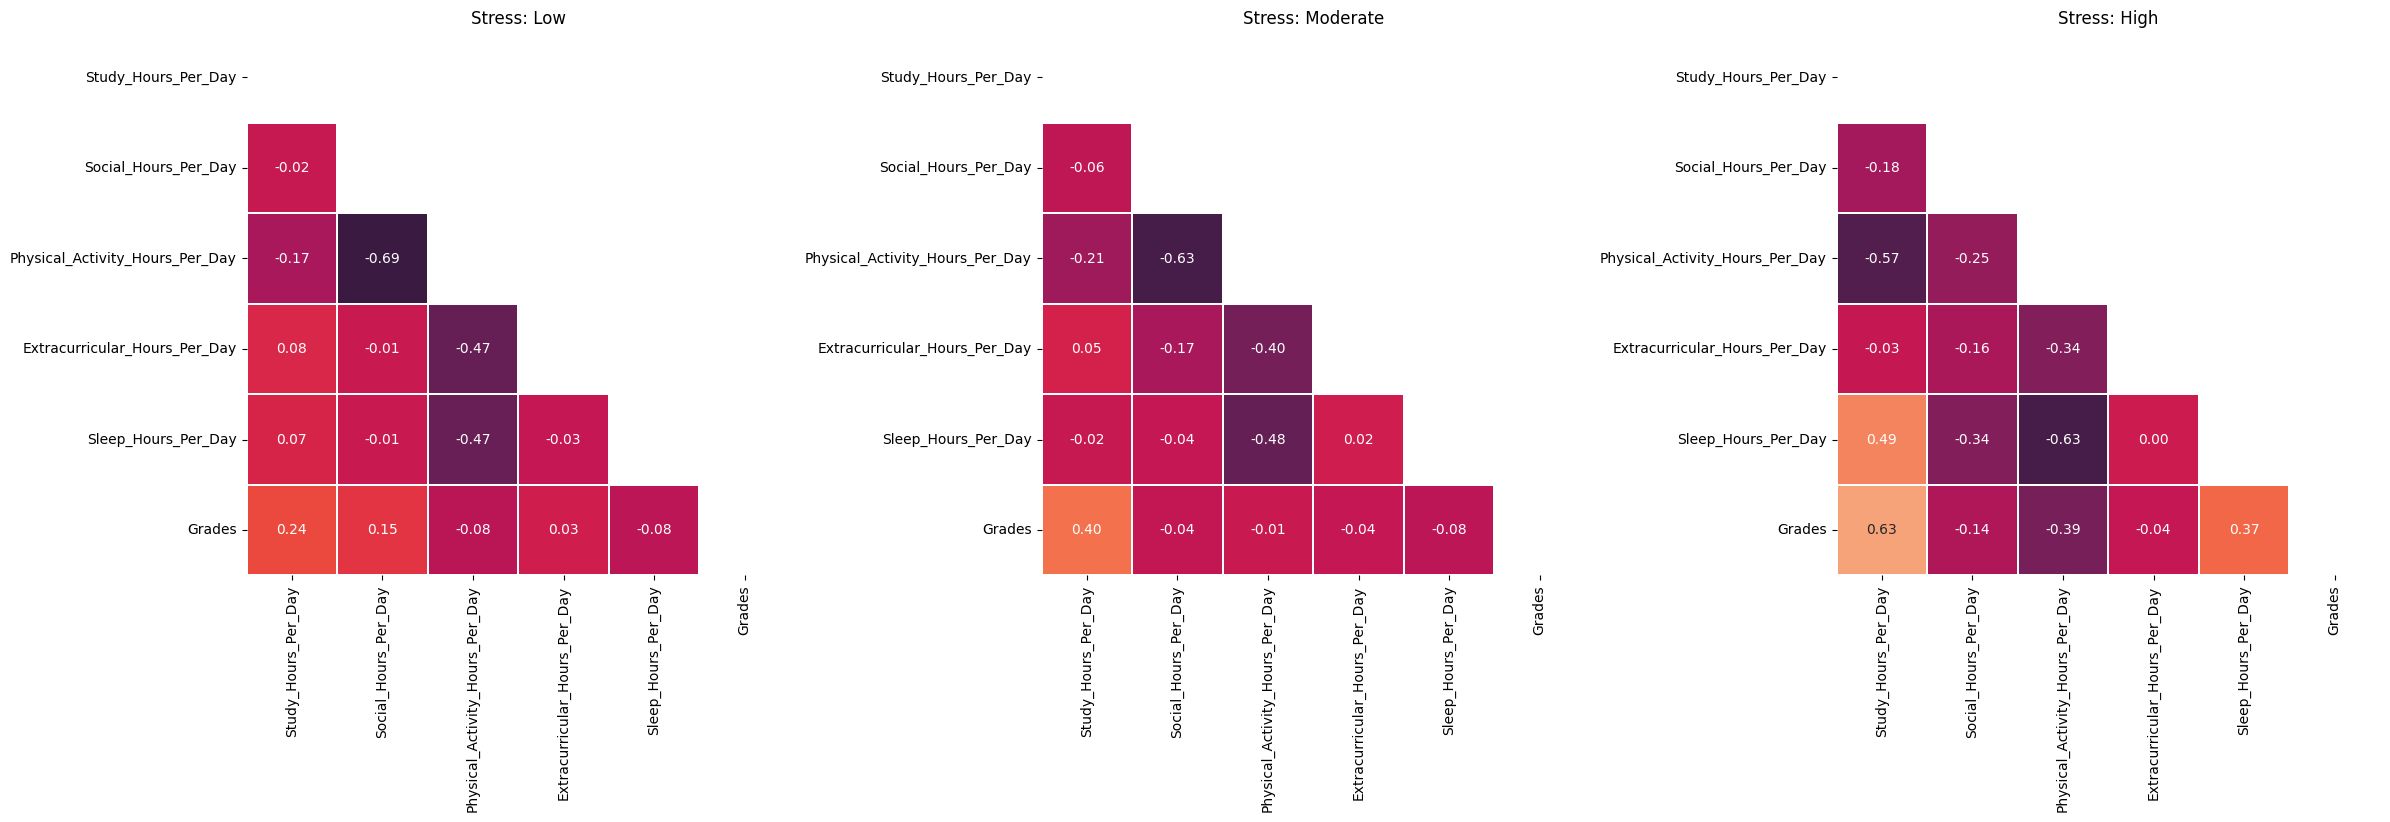

In [45]:
variables = [STUDY, SOCIAL, PHYSICAL, CLUBS, SLEEP, GRADES]
stress_levels = ['Low', 'Moderate', 'High']
n = len(stress_levels)

fig, axes = plt.subplots(1, n, figsize=(8 * n, 8), squeeze=False)

for i, stress_level in enumerate(stress_levels):
    ax = axes[0, i]
    group = df[df[STRESS] == stress_level]
    corr = group[variables].corr(method='spearman')

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="rocket",
        vmin=-1, vmax=1,
        center=0,
        mask=mask,
        linewidths=0.25,
        square=True,
        cbar=False,           # show colorbar on every heatmap
        ax=ax
    )
    ax.set_title(f"Stress: {stress_level}")
    ax.set_aspect('equal', adjustable='box')  # keep aspect ratio equal

plt.tight_layout()
plt.show()

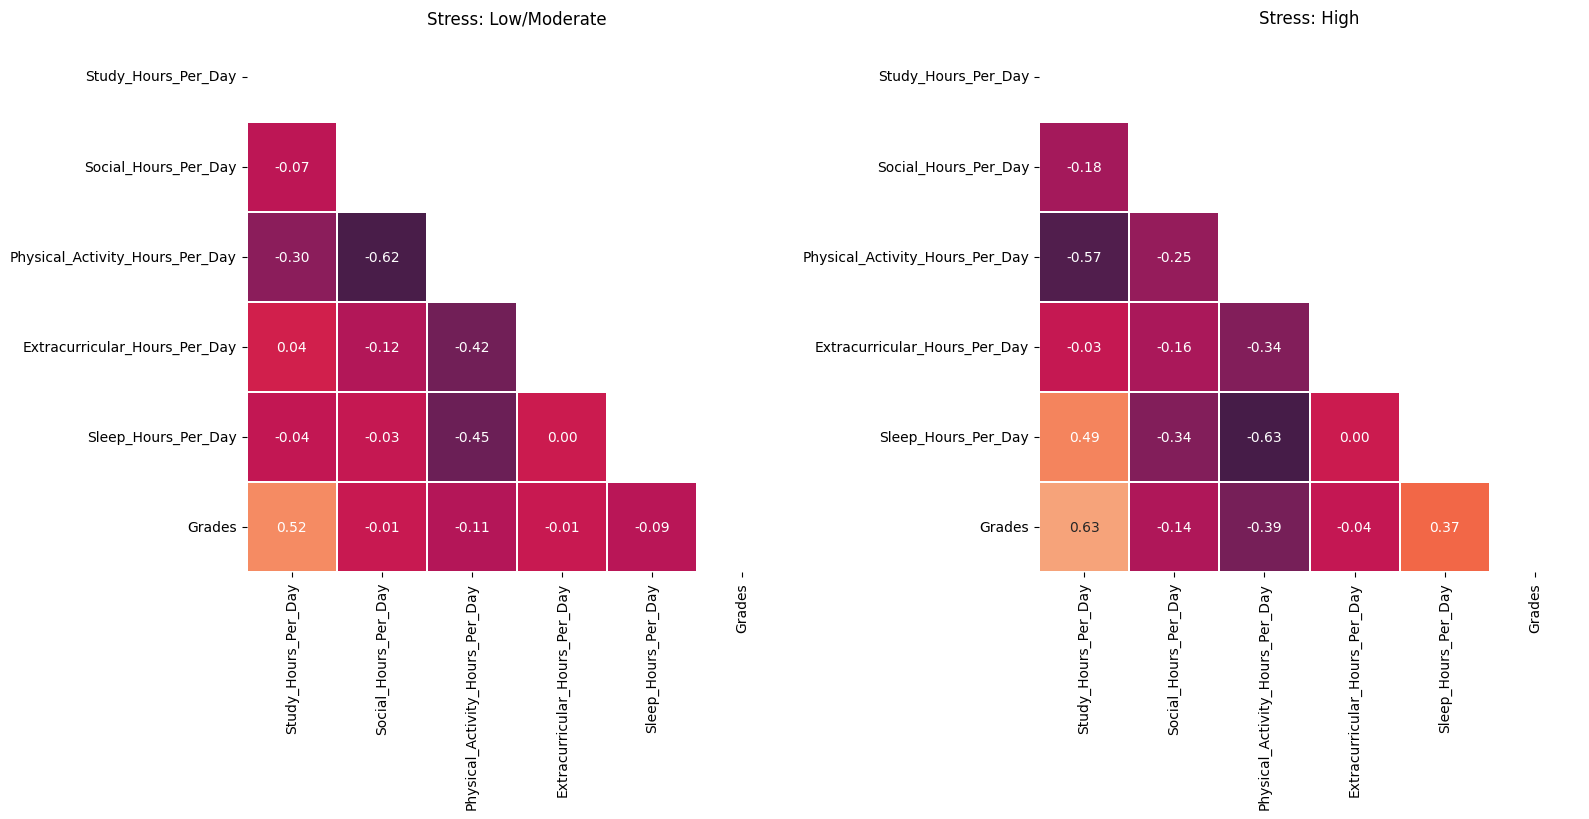

In [46]:
variables = [STUDY, SOCIAL, PHYSICAL, CLUBS, SLEEP, GRADES]
stress_levels = ['Low/Moderate', 'High']
n = len(stress_levels)

fig, axes = plt.subplots(1, n, figsize=(8 * n, 8), squeeze=False)

for i, stress_level in enumerate(stress_levels):
    ax = axes[0, i]
    group = df[df[STRESS_GROUPED] == stress_level]
    corr = group[variables].corr(method='spearman')

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="rocket",
        vmin=-1, vmax=1,
        center=0,
        mask=mask,
        linewidths=0.25,
        square=True,
        cbar=False,           # show colorbar on every heatmap
        ax=ax
    )
    ax.set_title(f"Stress: {stress_level}")
    ax.set_aspect('equal', adjustable='box')  # keep aspect ratio equal

plt.tight_layout()
plt.show()

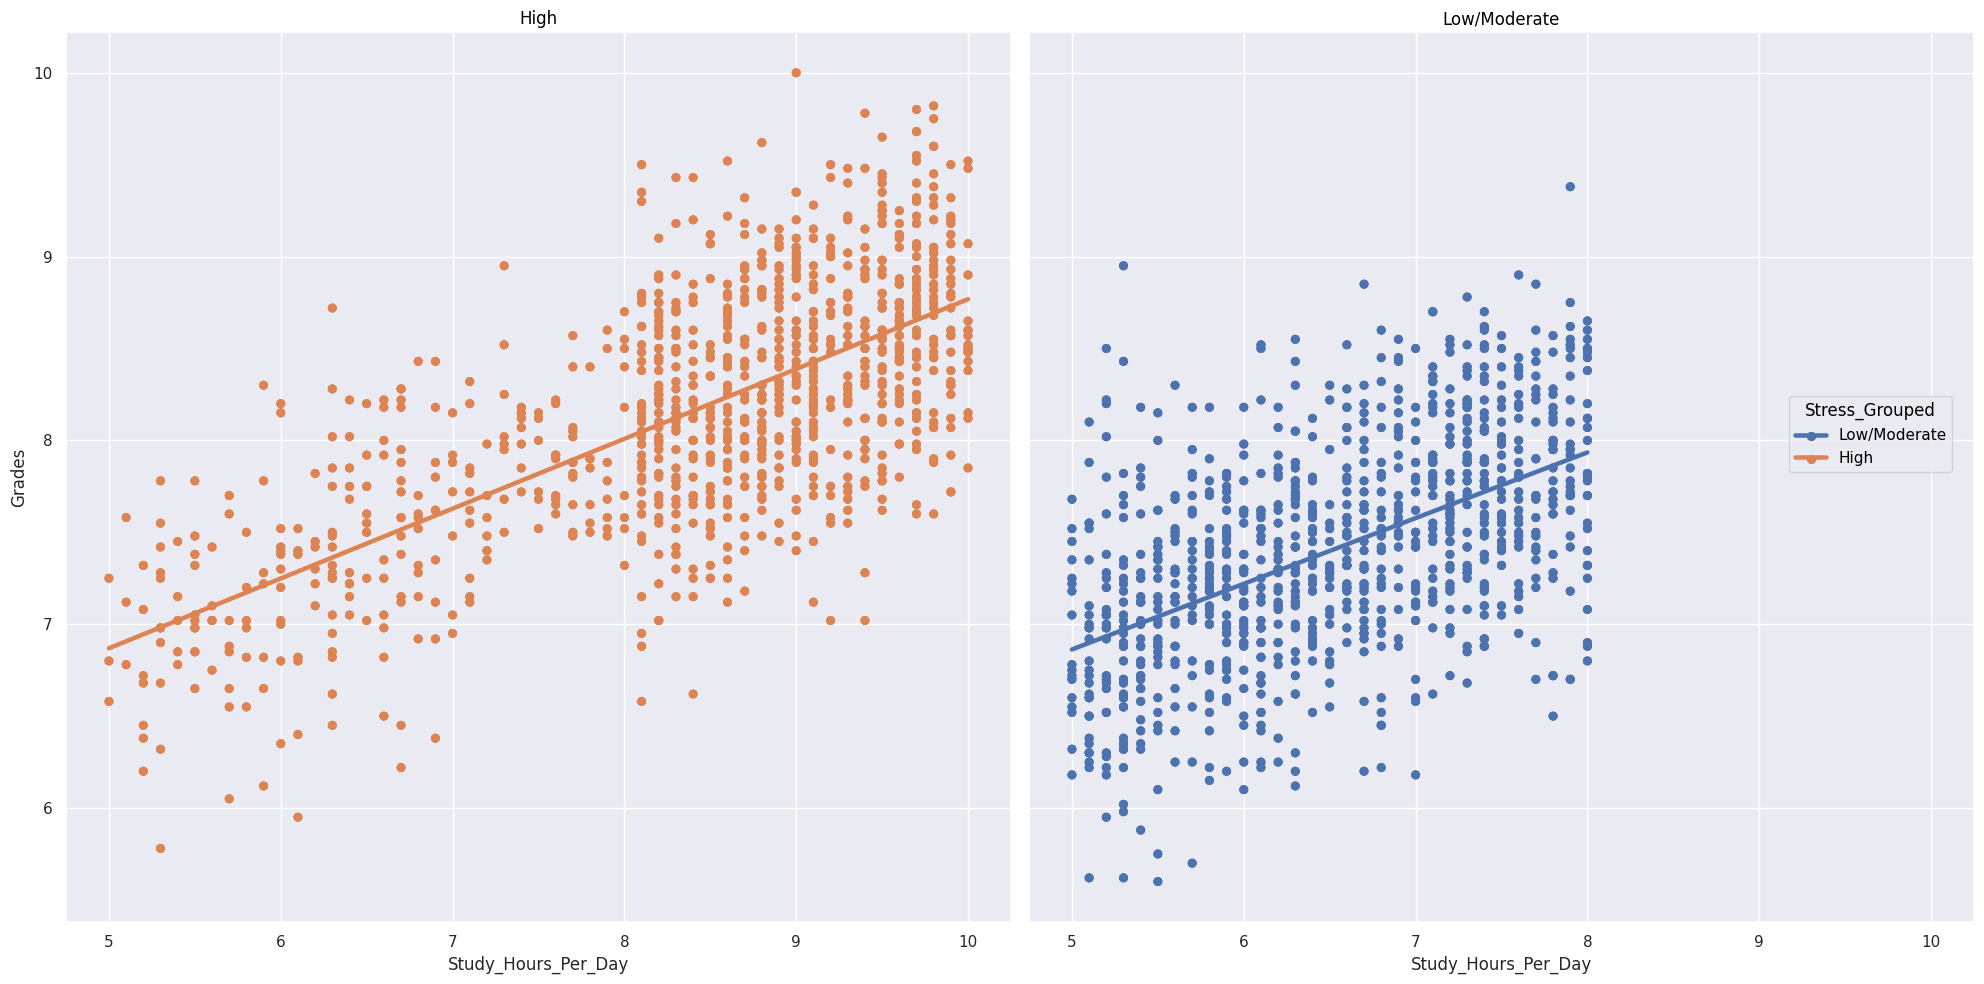

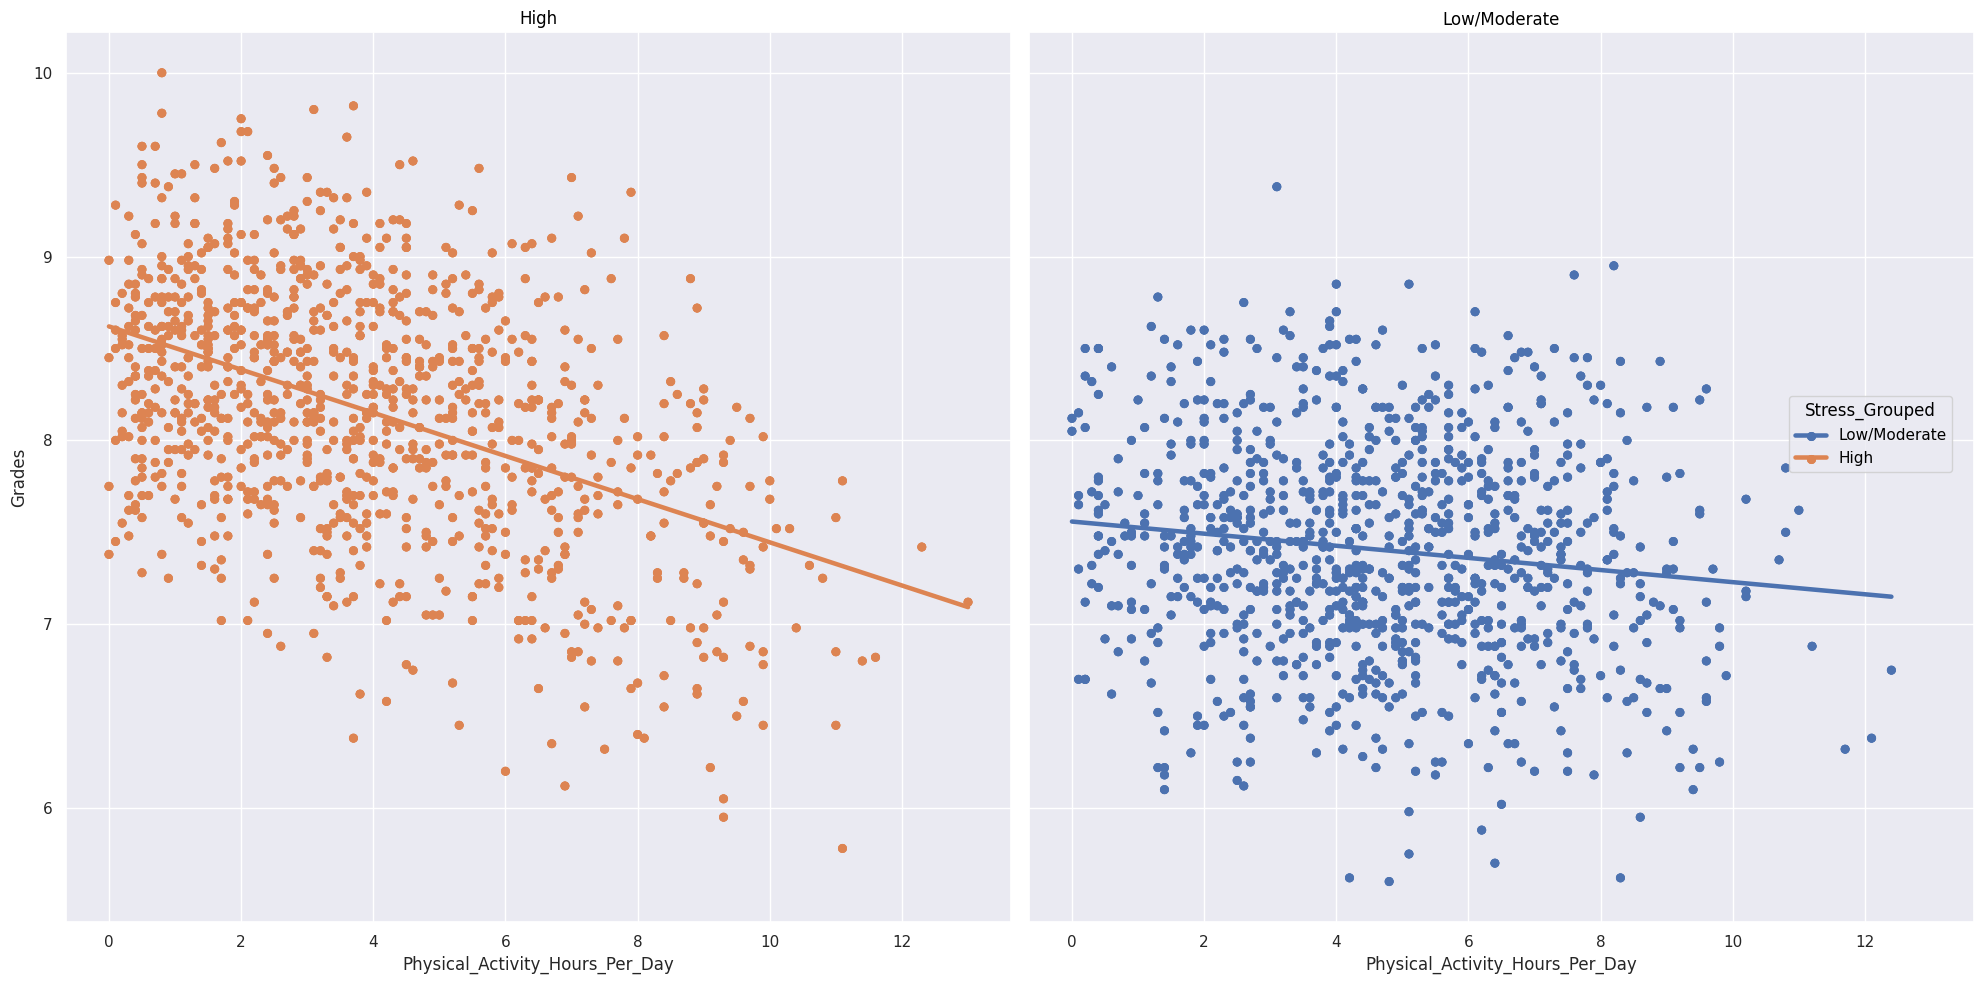

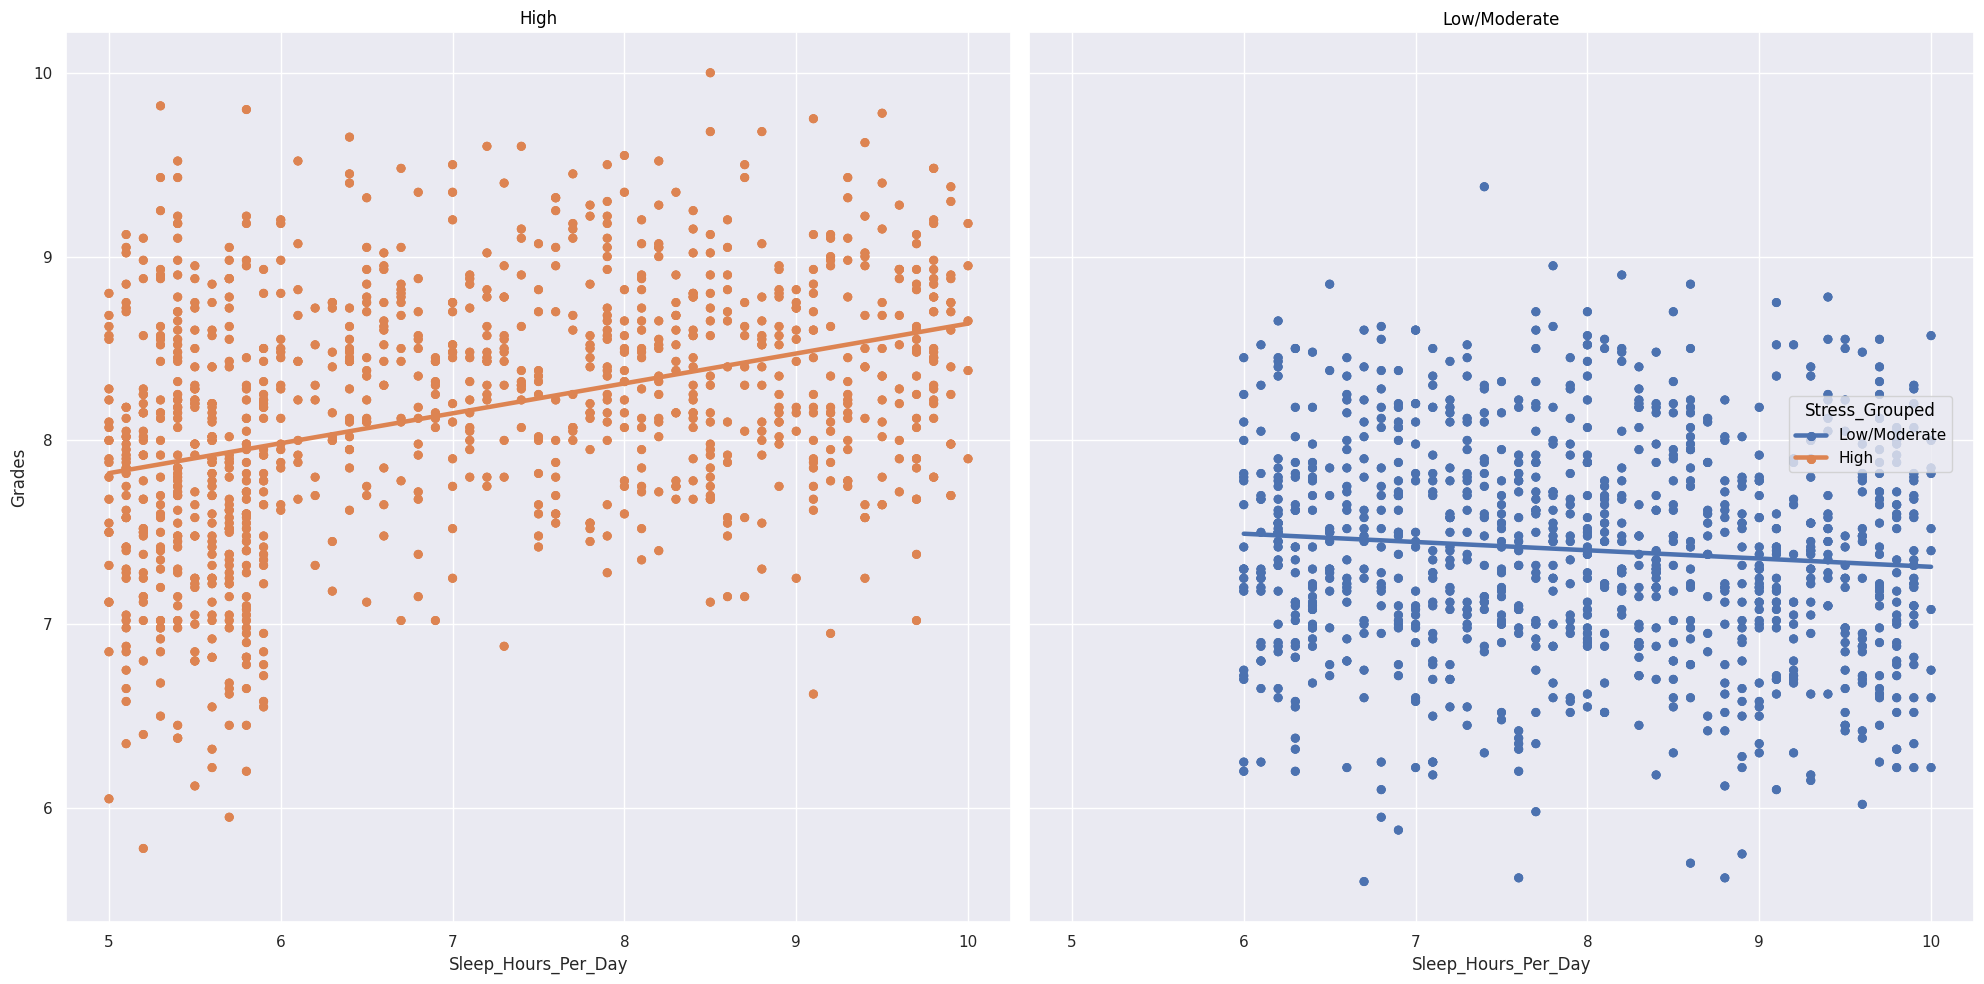

In [47]:
for x_axis, y_axis in [(STUDY, GRADES), (PHYSICAL, GRADES), (SLEEP, GRADES)]:
  (
    so.Plot(data=df, x=x_axis, y=GRADES, color=STRESS_GROUPED)
    .add(so.Dot())
    .add(so.Line(linewidth=3.25), so.PolyFit(order=1))
    .facet(col=STRESS_GROUPED)
    .layout(size=(20,10))
    .add(so.Dot())
    .show()
  )

# How sleep and study hours both influence grade in high stress students